# Assignment 2
#### By Hijun (Jane) Seo | 1001423284

## 0. Importing libraries

In [1]:
!pip install sklearn
# !pip install xgboost
!pip install nltk
!pip install bs4
!pip install wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import re, nltk
import string
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from keras.models import Sequential
from keras import layers
from keras.preprocessing import sequence
from keras.layers import Dense, Flatten, LSTM, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dropout, Activation
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/janeseo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/janeseo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using TensorFlow backend.


## 1. Importing data

In [2]:
tweets_original = open('generic_tweets.txt', 'r').read()

elections_original = pd.read_csv('Canadian_elections_2019.csv')

## 2. Data cleaning

### 2.1 Cleaning generic tweets data

In [3]:
tweetsList = tweets_original.split('\n')

We will drop the first element because it only contains the headings of the documents and the last element because it is empty.

In [4]:
del tweetsList[0]
del tweetsList[-1]

Each line contains comma, separated fields so we will the string at each comma.

In [5]:
split_tweets = [tw.split(',') for tw in tweetsList]

There are quotations around everything so we will get rid of them.

In [6]:
tweets = split_tweets.copy()
for i in range(len(split_tweets)):
    tweets[i] = [tw.strip('"') for tw in split_tweets[i]]

We will then split the list of strings into a sentiment list and a user and tweet list, where sentiment list is the target values and the user and tweet are the features.
The ID, date, and query of the tweet are not important in deciding if the tweet is positive or negative
since they are not relevant and/or are arbitrary.

In [7]:
sentiments = np.zeros(len(tweets))
user_tweet = tweets.copy()

for j in range(len(tweets)):
    sentiments[j] = int(tweets[j][0])
    user_tweet[j] = tweets[j][4:]
    if len(user_tweet[j]) > 2:
        for l in range(len(user_tweet[j]) - 2):
            user_tweet[j][1] = user_tweet[j][1] + user_tweet[j][2+l]
        user_tweet[j] = user_tweet[j][:2]

user_tweet = np.asarray(user_tweet)

The user (twitter handle), tweet content, and sentiment value will be saved to a dataframe called tweets_df.

In [8]:
tweets_df = pd.DataFrame ({
        'user': user_tweet[:, 0],
        'tweet': user_tweet[:, 1],
        'sentiment': sentiments
})

We will define a new function called clean_data that will take in a dataframe column as an input and output cleaned data in a new column of the dataframe. Stopwords are also given as an input to facilitate different stopword lists.

In [9]:
def clean_data(df, col_old, col_new, stopwords):
    
    # all characters in text are changed to lowercase
    df[col_new] = df[col_old].apply(lambda x: x.lower()).copy()
    
    # the elections data includes characters for new lines (i.e. \n)
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\n',''))
    
    # the elections data includes utf-8 emojis, which can show sentiment so replaced with emoji descriptions
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x82','face with tears of joy'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x83', 'smiling face with open mouth'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x89', 'winking face'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x8a', 'smiling face with smiling eyes'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x8b', 'face savouring delicious food'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x8d', 'smiling face with heart-shaped eyes'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x8f', 'smirking face'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x98\\xa0', 'angry face'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x98\\xa1', 'red angry face'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x98\\xa8', 'fearful face'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x98\\xad', 'loudly crying face'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x98\\xb1', 'face screaming in fear'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x98\\xb3', 'flushed face'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x99\\x8c', 'person raising both hands in celebration'))
    df[col_new] = df[col_new].apply(lambda x: x.replace('\\xf0\\x9f\\x99\\x8f', 'person with folded hands'))

    # some characters/punctuation like quotations or dashes in the elections data were in utf-8 (hex)
    # so these will be removed
    df[col_new] = df[col_new].apply(lambda x: re.sub(r'\\x\S+\\x\S+\\x\S+', '', x))
    df[col_new] = df[col_new].apply(lambda x: re.sub(r'\\x\S+\\x\S+', '', x))

    # all mentions, retweet tags, and htmls are removed
    df[col_new] = df[col_new].apply(lambda x: re.sub(r'(@[\w]+)|(^rt\s+)|(http\S+)',' ', x))

    # all HTML character codes will be replaced with ASCII equivalents
    df[col_new] = df[col_new].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())
    
    # all repeating characters of more than 2 times will be removed (e.g. awww --> aw)
    df[col_new] = df[col_new].apply(lambda x: re.sub(r'(.)\1{2,}', r'\1\1', x))

    # all tweets will be tokenized (and later joined together) to remove unnecessary white space
    df[col_new] = df[col_new].apply(lambda x: re.split('\W+', x))
    
    # all punctuation will be removed
    df[col_new] = df[col_new].apply(lambda x: [char for char in x if char not in string.punctuation])
    
    # all stopwords will be removed (stopwords will be defined outside the function and required as an input)
    df[col_new] = df[col_new].apply(lambda x: [word for word in x if word not in stopwords])
    
    # all words will be stemmed (e.g. snowed and snowing --> snow because same word but different tense)
    df[col_new] = df[col_new].apply(lambda x: [nltk.PorterStemmer().stem(word) for word in x])
    
    # join all words back together
    df[col_new] = df[col_new].apply(lambda x: ' '.join(x))
    
    return df[col_new]

#### Defining stopwords

The typical stopwords for english as defined by the nltk library are shown below.

In [10]:
nltk_stopwords = stopwords.words('english')
print(nltk_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

A lot of these words may show sentiment. Words like for, no, nor, not, can, will, but, against, why, how, so, don, don't, should, should've, ain, aren, aren't, couldn, couldn't, didn, didn't, does, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, mightn, mightn't, mustn', mustn't, needn, needn't, shan, shan't, shouldn, shouldn't, wasn, wasn't, weren, weren't, won, won't, wouldn, wouldn't all may be important in recognizing senitment. For example, 'Why didn't he do this?', 'It doesn't make sense', 'He shouldn't have done that' all show a negative sentiment using some of the words that have been defined as a stopword.

Removing these potentially useful words as stopwords, we can define our list of stopwords as follows.

In [11]:
new_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'than', 'too', 'very', 's', 't', 'just']
print(new_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'than', 'too', 'very', 's', 't', 'just']


Using these new stopwords, we will clean the generic tweet data using the defined clean_data function.

In [12]:
cleaned_tweets = clean_data(tweets_df, 'tweet', 'tweet_cleaned', new_stopwords)
cleaned_tweets.head()

0        aww bummer shoulda got david carr third day d
1    upset can updat facebook text might cri result...
2    dive mani time for ball manag save 50 rest go ...
3                      whole bodi feel itchi like fire
4                       no not behav m mad whi can see
Name: tweet_cleaned, dtype: object

Since sentiment values are either 0 or 4, for more 'binary'-like structure, all 4's will be replaced with 1's.

In [13]:
tweets_df['sentiment'] = tweets_df['sentiment'].replace(to_replace=4.0, value=1)

### 2.2 Cleaning elections data

In [14]:
elections_original.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


Text column will be cleaned the same way as with generic tweets using clean_data function and same stopwords.

In [15]:
cleaned_elections = clean_data(elections_original, 'text', 'text_cleaned', new_stopwords)
cleaned_elections.head()

0    b so instead suggest how agre canadian women c...
1    b allwomanspacewalk real etobicokenorth cityof...
2    b brantford go cost 94 billion for next 4 year...
3    b canada canadaelection2019 canadavot elxn43 c...
4    b canada taxpay sick tire hard earn donat corp...
Name: text_cleaned, dtype: object

The text data also has a 'b' in front of every line so this will be removed.

In [16]:
elections_original['text_cleaned'] = elections_original['text_cleaned'].apply(lambda x: x[2:])
cleaned_elections = elections_original['text_cleaned']
cleaned_elections.head()

0    so instead suggest how agre canadian women can...
1    allwomanspacewalk real etobicokenorth cityofto...
2    brantford go cost 94 billion for next 4 year a...
3    canada canadaelection2019 canadavot elxn43 can...
4    canada taxpay sick tire hard earn donat corpor...
Name: text_cleaned, dtype: object

Sentiment of elections data is positive or negative so to this can be represented by 0 = negative, 1 = positive.

In [17]:
elections_original['sentiment'] = elections_original['sentiment'].replace(to_replace=['negative', 'positive'], value=[0, 1])

The negative sentiment column will also be made so that all words are lowercase for easier recognition of similar reasons.

In [18]:
elections_original['negative_reason'] = elections_original['negative_reason'].replace(to_replace=np.NaN, value='nan')
elections_original['negative_reason'] = elections_original['negative_reason'].apply(lambda x: x.lower())

## Exploratory analysis

Using relevant words and hashtags like 'Justin' or 'Trudeau' or 'Liberal', we will see the distribution of political affiliation in the tweets.

In [19]:
liberal = elections_original[elections_original['text'].str.contains('justin|trudeau|liberal|forward', case=False)]

lib_mean = liberal['sentiment'].mean(axis=0)
lib_sum = liberal['sentiment'].sum(axis=0)
lib_length = len(liberal)

conservative = elections_original[elections_original['text'].str.contains('andrew|scheer|conservative|tories', case=False)]
con_mean = conservative['sentiment'].mean(axis=0)
con_sum = conservative['sentiment'].sum(axis=0)
con_length = len(conservative)

ndp = elections_original[elections_original['text'].str.contains('jagmeet|singh|ndp|democratic|democrat', case=False)]
ndp_mean = ndp['sentiment'].mean(axis=0)
ndp_sum = ndp['sentiment'].sum(axis=0)
ndp_length = len(ndp)

none_tweet = elections_original[~elections_original['text'].str.contains('justin|trudeau|liberal|forward|andrew|scheer|conservative|tories|jagmeet|singh|ndp|democratic|democrat', case=False)]
none_mean = none_tweet['sentiment'].mean(axis=0)
none_sum = none_tweet['sentiment'].sum(axis=0)
none_length = len(none_tweet)

elections_data = {'length': [lib_length, con_length, ndp_length, none_length], 'sum': [lib_sum, con_sum, ndp_sum, none_sum], 'mean': [lib_mean, con_mean, ndp_mean, none_mean]}
elections_df = pd.DataFrame(data=elections_data, index=['Liberal', 'Conservative', 'NDP', 'None/Other'])

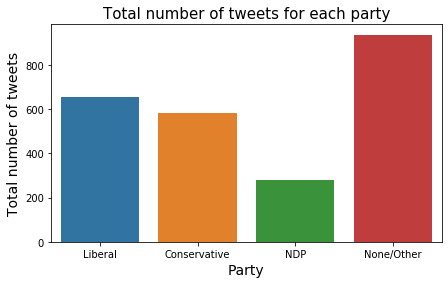

In [20]:
plt.figure(figsize=(7,4))
barplot = sns.barplot(x=elections_df.index, y=elections_df['length'])
ax = barplot.axes
plt.ylabel("Total number of tweets", fontsize=14)
plt.xlabel("Party", fontsize=14)
plt.title("Total number of tweets for each party", fontsize=15)
plt.show()

Liberal and Conservaitve parties were mentioned similar number of times, while NDP was tweeted about less number of times. However, most tweets were not related to Liberal, Conservative, or NDP.

#### Note: We will take a closer look at what constitutes a tweet classified as 'None/Other' in the Bonus section at the bottom of the notebook.

Going back to the tweets related to the Liberal, Conservative, and NDP parties, when we plot the total number of positive tweets for each party, we can see that Liberal has the most number of positive tweets, then Conservative, and finally NDP.

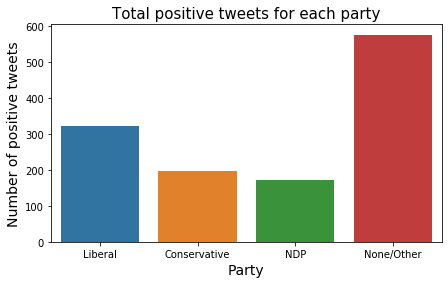

In [21]:
plt.figure(figsize=(7,4))
barplot = sns.barplot(x=elections_df.index, y=elections_df['sum'])
ax = barplot.axes
plt.ylabel("Number of positive tweets", fontsize=14)
plt.xlabel("Party", fontsize=14)
plt.title("Total positive tweets for each party", fontsize=15)
plt.show()

Comparing the total positive tweets bar graph to the total tweets per party bar graph, one thing we can see is that although the Conservative party had similar number of tweets as Liberals, Conservative had much less positive tweets than Liberals. So much so that the number of positive tweets related to the Conservative party and the NDP party are similar.

Plotting the total negative tweets for each party, we can see that Conservatives had the most number of negative tweets, while NDP had very few negative tweets.

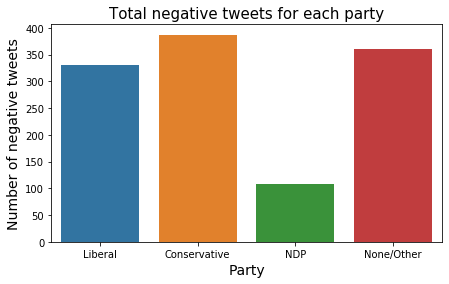

In [22]:
plt.figure(figsize=(7,4))
barplot = sns.barplot(x=elections_df.index, y=elections_df['length']-elections_df['sum'])
ax = barplot.axes
plt.ylabel("Number of negative tweets", fontsize=14)
plt.xlabel("Party", fontsize=14)
plt.title("Total negative tweets for each party", fontsize=15)
plt.show()

This is more clear to see when the ratios of positive to negative tweets are plotted.

Text(0.5, 1.0, 'Ratio of positive to negative tweets for each party')

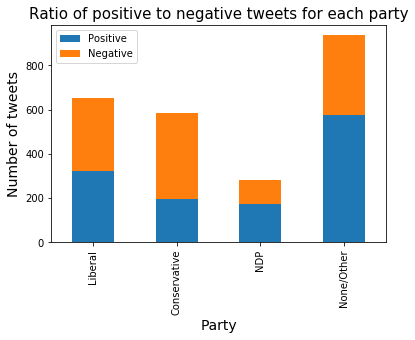

In [23]:
pos_neg = {'Positive': [lib_sum, con_sum, ndp_sum, none_sum], 'Negative': [len(liberal)-lib_sum, len(conservative)-con_sum, len(ndp)-ndp_sum, len(none_tweet)-none_sum]}
pos_neg_df = pd.DataFrame(data=pos_neg, index=['Liberal', 'Conservative', 'NDP', 'None/Other'])
pos_neg_df.plot(kind='bar',stacked=True)
plt.ylabel("Number of tweets", fontsize=14)
plt.xlabel("Party", fontsize=14)
plt.title("Ratio of positive to negative tweets for each party", fontsize=15)

The data shows some correlation with what actually happened during the elections. As was seen during elections, Liberal and Conservatives were the most popular two parties, gaining the majority of votes. However, the ratio of positive to negative tweets shows that Liberals were looked upon more favourably by Canadians. This was not reflected in the number of popular votes since Conservative received more total number of votes. This may be because the data lacks geographical information. If, for example, there was data that showed that the majority of these tweets were made by users in Ontario, it would have correctly predicted that the majority of the seats would be won by Liberals.

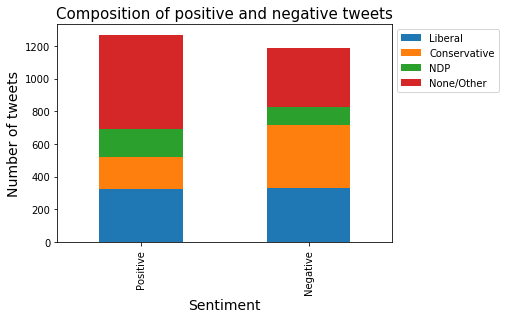

In [24]:
posneg_flipped = {'Liberal': [lib_sum, len(liberal)-lib_sum], 'Conservative': [con_sum, len(conservative)-con_sum],
             'NDP': [ndp_sum, len(ndp)-ndp_sum], 'None/Other': [none_sum, len(none_tweet)-none_sum]}
posneg_flipped_df = pd.DataFrame(data=posneg_flipped, index=['Positive', 'Negative'])
posneg_flipped_df.plot(kind='bar',stacked=True)
plt.ylabel("Number of tweets", fontsize=14)
plt.xlabel("Sentiment", fontsize=14)
plt.title("Composition of positive and negative tweets", fontsize=15)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

The above composition graph shows that the majority of positive tweets weren't associated with a particular party. This may be tweets like the ones discussed above where people are encouraging others to vote.

The graph also shows the majority of negative tweets are associated with the Conservative party.

We will now observe word clouds of the top used words for positive and negative tweets in the generic tweets data and the elections data.

In [25]:
positive_generic = tweets_df[tweets_df['sentiment'] == 1]
negative_generic = tweets_df[tweets_df['sentiment'] == 0]

positive_elections = elections_original[elections_original['sentiment'] == 1]
negative_elections = elections_original[elections_original['sentiment'] == 0]

In [26]:
# The word_cloud_clean function is very similar to the clean_data function except is does not stem the words
# since this will make the word cloud harder to read.
# It also does not include removal of stopwords in the function since stopwords can be defined when makeing the word cloud.

def word_cloud_clean(df, col):
    sentiment_tweet = df[col].apply(lambda x: x.lower())
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\n',''))
    
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x82','face with tears of joy'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x83', 'smiling face with open mouth'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x89', 'winking face'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x8a', 'smiling face with smiling eyes'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x8b', 'face savouring delicious food'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x8d', 'smiling face with heart-shaped eyes'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x98\\x8f', 'smirking face'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x98\\xa0', 'angry face'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x98\\xa1', 'red angry face'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x98\\xa8', 'fearful face'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x98\\xad', 'loudly crying face'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x98\\xb1', 'face screaming in fear'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x98\\xb3', 'flushed face'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x99\\x8c', 'person raising both hands in celebration'))
    sentiment_tweet = sentiment_tweet.apply(lambda x: x.replace('\\xf0\\x9f\\x99\\x8f', 'person with folded hands'))

    sentiment_tweet = sentiment_tweet.apply(lambda x: re.sub(r'\\x\S+\\x\S+\\x\S+', '', x))
    sentiment_tweet = sentiment_tweet.apply(lambda x: re.sub(r'(@[\w]+)|(^rt\s+)|(http\S+)',' ', x))
    sentiment_tweet = sentiment_tweet.apply(lambda x: BeautifulSoup(x, 'lxml').get_text())
    sentiment_tweet = sentiment_tweet.apply(lambda x: re.sub(r'(.)\1{2,}', r'\1\1', x))
    sentiment_tweet = sentiment_tweet.apply(lambda x: re.split('\W+', x))
    sentiment_tweet = sentiment_tweet.apply(lambda x: [char for char in x if char not in string.punctuation])
    sentiment_tweet = sentiment_tweet.apply(lambda x: ' '.join(x))
    onestring = " ".join(tweet for tweet in sentiment_tweet)
    return onestring

In [27]:
def word_cloud(df, col, stopwords):
    all_words = word_cloud_clean(df, col)
    wordcloud = WordCloud(collocations=False, stopwords=stopwords, background_color="white").generate(all_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

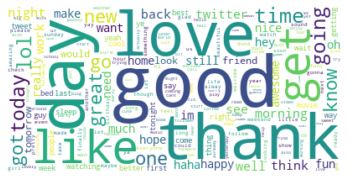

In [28]:
word_cloud(positive_generic, 'tweet', nltk_stopwords)

Generic tweets show that the words most associated with a positive sentiment include good, love, lol and thank.

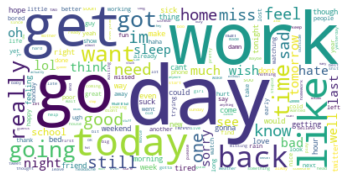

In [29]:
word_cloud(negative_generic, 'tweet', nltk_stopwords)

Generic tweets also show that the words most associated with a negative sentiment include work, get, go, and today.

Notice that there are some overlap in the words associated with both positive and negative sentiments, such as day and like. This may be because these are commonly used words wihtin tweets. Although these words can be defined as stopwords, it may be helpful for the algorithms to use these features since there is some difference in the frequency in the appearance of these words within the negative pool and positive pool of tweets.

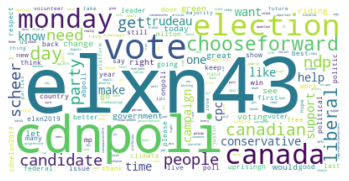

In [30]:
word_cloud(positive_elections, 'text', nltk_stopwords)

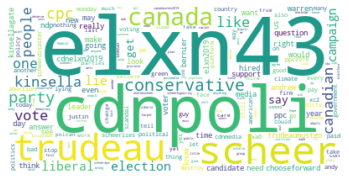

In [31]:
word_cloud(negative_elections, 'text', nltk_stopwords)

Looking at the most common positive and negative words, we can see the biggest words are elxn43 and cdnpoli, which are both hashtags for referring to the election and canadian politics. These can be removed by adding these words to the stopwords list.

In [32]:
nltk_stopwords = set(stopwords.words('english'))
common_hash = ['cdnpoli', 'elxn43']
updated_stopwords = nltk_stopwords.union(common_hash)

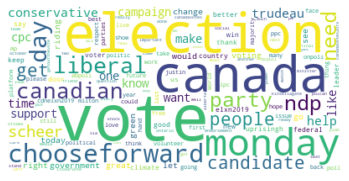

In [33]:
word_cloud(positive_elections, 'text', updated_stopwords)

Looking at the biggest words, we can see that election, Monday, vote, and Canada are the most common words associated with a positive sentiment for the elections data. This may be because the majority of the positive elections data weren't associate with a particular party and were more focused on encouraging people to vote.

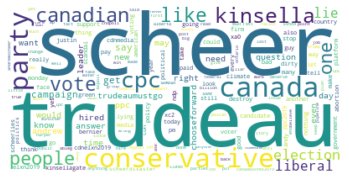

In [34]:
word_cloud(negative_elections, 'text', updated_stopwords)

The biggest words in this word cloud for negative election tweets shows that the words Scheer Trudeau and Conservative. This shows most negative tweets are directed towards certain parties, and as also seen above in the bar graphs, Conservatives overall have more negative tweets than Liberal.

## 3.1 Model preparation for sentiment value prediction

Split the generic tweets randomly into training data (70%) and test data (30%). Prepare the data to try multiple classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (RF, XGBoost)), where each tweet is considered a single observation/example. In these models, the target variable is the sentiment value, which is either positive or negative. Try two different types of features, Bag of words (word frequency) and TF-IDF.

Two different methods of vectorizing the text data will be attempted: bag of words and TF-IDF. These two methods will be defined as functions since the max_features can be selected and this is a parameter that may need to be tuned later on for optimizing model accuracy. Max_features allows us to select the top x words that appear in the data and only uses those vectorizes/uses those words. Thus, more words may mean overfitting, while too few words may mean underfitting.

In [35]:
def count_vect(mf):
    count = CountVectorizer(max_features=mf)
    return count
def tfidf_vect(mf):
    tfidf = TfidfVectorizer(max_features=mf)
    return tfidf

### Preparation using bag of words

In [36]:
count_vectorizer = count_vect(100)
tweets_countvect = count_vectorizer.fit_transform(tweets_df['tweet_cleaned'])
tweets_countvect = tweets_countvect.toarray()
tweets_countvect_features = count_vectorizer.get_feature_names()

In [37]:
X_countvect = pd.DataFrame(tweets_countvect, columns=tweets_countvect_features)
y_countvect = tweets_df['sentiment'].copy()

In [38]:
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X_countvect, y_countvect, test_size=0.3, random_state=42)

### Preparation using TF-IDF

In [39]:
tfidf_vectorizer = tfidf_vect(100)
tweets_tfidfvect = tfidf_vectorizer.fit_transform(tweets_df['tweet_cleaned'])
tweets_tfidfvect = tweets_tfidfvect.toarray()
tweets_tfidfvect_features = tfidf_vectorizer.get_feature_names()

In [40]:
X_tfidfvect = pd.DataFrame(tweets_tfidfvect, columns=tweets_tfidfvect_features)
y_tfidfvect = tweets_df['sentiment'].copy()

In [41]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidfvect, y_tfidfvect, test_size=0.3, random_state=42)

## 3.2 Model implementation for sentiment value prediction

Note: Although most the default settings were used for most models, KNN was restricted to K=2 and SVM was restricted to max 1000 iterations since the models were taking too long to implement.

In [42]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=2, n_jobs=-1)))
models.append(('NB', BernoulliNB()))
models.append(('SVM', SVC(max_iter=1000)))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))

In [43]:
def train_test(X_train, X_test, y_train, y_test, models, save=False):
    for name, model in models:
        if name == 'XGB':
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            train_predict = [round(value) for value in y_pred_train]
            y_pred_test = model.predict(X_test)
            test_predict = [round(value) for value in y_pred_test]
        else:
            model.fit(X_train, y_train)
            train_predict = model.predict(X_train)
            test_predict = model.predict(X_test)
            
        train_acc = f1_score(train_predict, y_train, average='micro')
        test_acc = f1_score(test_predict, y_test, average='micro')

        print('With model', name, ', train f1:', train_acc, ', and test f1:', test_acc)
    if save==True:
        return test_predict
    else:
        return None


Only the top 100 used words were vectorized and used for preliminary training and testing since some models take very long to run. Although this won't give the best results since there are so few features to make the prediction on, it will reduce the time needed to compare all 8 models. More features will be used train on all generic tweet data and to make the actual sentiment prediction on elections data.

The F1-score takes into consideration both the precision and recall, which is ideal for predicting sentiment since neither false negatives nor false positives is worse than the other. Specifically, F1-micro will be calculated since it treats each test case equally and doesn't give advantages to small classes.

Using the data vectorized using bag of words, we get the following f1 scores.

In [44]:
# Commented out since it takes very long to run. The results are written below.

# train_test(X_train_count, X_test_count, y_train_count, y_test_count, models)

With model LR , train f1: 0.6763642857142858 , and test f1: 0.6796333333333333

With model KNN , train f1: 0.6994642857142858 , and test f1: 0.6011166666666666

With model NB , train f1: 0.6707357142857143 , and test f1: 0.6749666666666667

With model SVM , train f1: 0.5001071428571429 , and test f1: 0.5035833333333334

With model DT , train f1: 0.8234714285714285 , and test f1: 0.6433833333333333

With model RF , train f1: 0.8160857142857143 , and test f1: 0.66555

With model XGB , train f1: 0.6683785714285714 , and test f1: 0.6703666666666667

Using the data vectorized using TF-IDF, we get the following f1 scores.

In [45]:
# Commented out since it takes very long to run. The results are written below.

# train_test(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, models)

With model LR , train f1: 0.6754071428571429 , and test f1: 0.6786

With model KNN , train f1: 0.7025714285714286 , and test f1: 0.6019

With model NB , train f1: 0.6707357142857143 , and test f1: 0.6749666666666667

With model SVM , train f1: 0.5515714285714286 , and test f1: 0.5547166666666666

With model DT , train f1: 0.8229785714285714 , and test f1: 0.6492666666666667

With model RF , train f1: 0.8148000000000001 , and test f1: 0.6662

With model XGB , train f1: 0.6701714285714285 , and test f1: 0.6706333333333333

#### The best f1 score is achieved using logistic regression on data that has been vectorized using bag of words. Thus, we will be using this method to predict elections data.

Now that we have identified the best model as logistic regression, which does not take long to fit and predict, 4000 features will be used.

#### Note: Finding optimal number of features was investigated in the 'Bonus' section.

In [46]:
count_vectorizer = count_vect(4000)
tweets_vect = count_vectorizer.fit_transform(tweets_df['tweet_cleaned'])
tweets_vect = tweets_vect.toarray()
tweets_vect_features = count_vectorizer.get_feature_names()

In [47]:
X_train = pd.DataFrame(tweets_vect, columns=tweets_vect_features)
y_train = tweets_df['sentiment'].copy()

In [48]:
elections_vect = count_vectorizer.transform(elections_original['text_cleaned'])
elections_vect = elections_vect.toarray()
elections_vect_features = count_vectorizer.get_feature_names()

In [49]:
X_test = pd.DataFrame(elections_vect, columns=elections_vect_features)
y_test = elections_original['sentiment'].copy()

In [50]:
bestmodel = LogisticRegression()
bestmodel.fit(X_train, y_train)
train_predict = bestmodel.predict(X_train)
test_predict = bestmodel.predict(X_test)
            
train_acc = f1_score(train_predict, y_train, average='micro')
test_acc = f1_score(test_predict, y_test, average='micro')

print('With model Logistic Regression, train f1:', train_acc, ', and test f1:', test_acc)

With model Logistic Regression, train f1: 0.788585 , and test f1: 0.6380684481950305


With model Logistic Regression , train f1: 0.788585 , and test f1: 0.6380684481950305

In [51]:
elections_original['predicted'] = test_predict

## 3.3 Results of first model for predicting sentiment values

In [52]:
print(classification_report(y_test,test_predict))

              precision    recall  f1-score   support

           0       0.64      0.53      0.58      1006
           1       0.64      0.74      0.68      1127

    accuracy                           0.64      2133
   macro avg       0.64      0.63      0.63      2133
weighted avg       0.64      0.64      0.63      2133



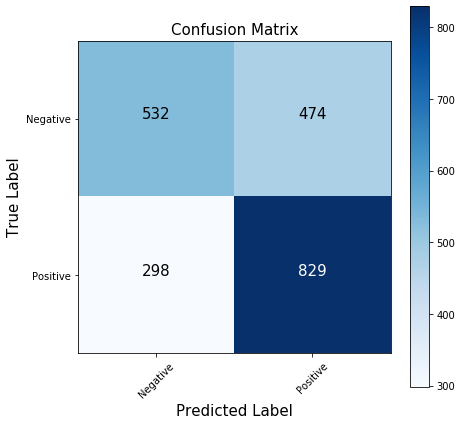

In [53]:
cm = confusion_matrix(y_test,test_predict)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(np.sort(np.unique(y_test))))
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45, fontsize=10)
plt.yticks(tick_marks, ['Negative', 'Positive'], fontsize=10)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 600:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

The model is able to predict positive tweets very well, but it has a harder time predicting negative tweets.

In [54]:
liberal = elections_original[elections_original['text'].str.contains('justin|trudeau|liberal|forward', case=False)]
pred_lib_mean = liberal['predicted'].mean(axis=0)
pred_lib_sum = liberal['predicted'].sum(axis=0)

conservative = elections_original[elections_original['text'].str.contains('andrew|scheer|conservative|tories', case=False)]
pred_con_mean = conservative['predicted'].mean(axis=0)
pred_con_sum = conservative['predicted'].sum(axis=0)

ndp = elections_original[elections_original['text'].str.contains('jagmeet|singh|ndp|democratic|democrat', case=False)]
pred_ndp_mean = ndp['predicted'].mean(axis=0)
pred_ndp_sum = ndp['predicted'].sum(axis=0)

none_tweet = elections_original[~elections_original['text'].str.contains('justin|trudeau|liberal|forward|andrew|scheer|conservative|tories|jagmeet|singh|ndp|democratic|democrat', case=False)]
pred_none_mean = none_tweet['predicted'].mean(axis=0)
pred_none_sum = none_tweet['predicted'].sum(axis=0)

pred_elections_data = {'sum': [pred_lib_sum, pred_con_sum, pred_ndp_sum, pred_none_sum], 'mean': [pred_lib_mean, pred_con_mean, pred_ndp_mean, pred_none_mean]}
pred_elections_df = pd.DataFrame(data=pred_elections_data, index=['Liberal', 'Conservative', 'NDP', 'None/Other'])

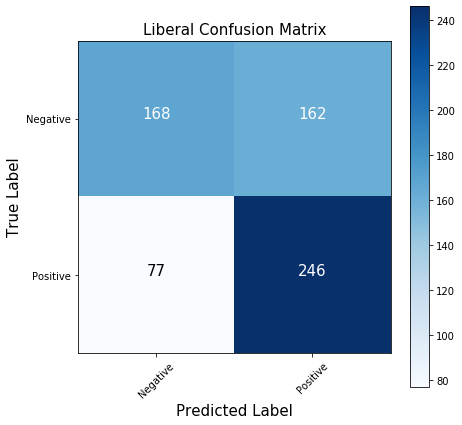

In [55]:
cm = confusion_matrix(liberal['sentiment'], liberal['predicted'])
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Liberal Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45, fontsize=10)
plt.yticks(tick_marks, ['Negative', 'Positive'], fontsize=10)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 100:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

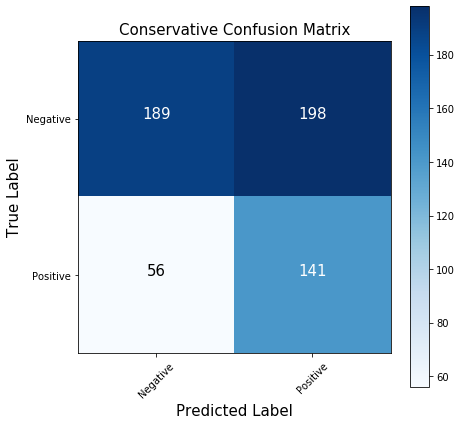

In [56]:
cm = confusion_matrix(conservative['sentiment'], conservative['predicted'])
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Conservative Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45, fontsize=10)
plt.yticks(tick_marks, ['Negative', 'Positive'], fontsize=10)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 100:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

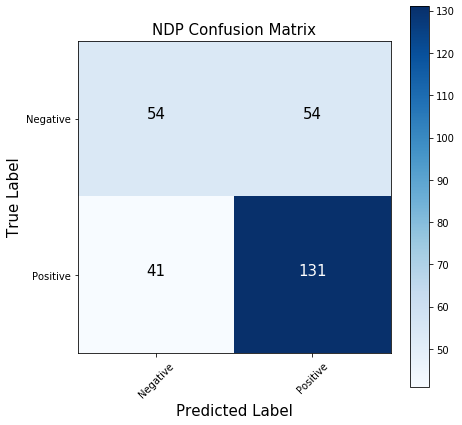

In [57]:
cm = confusion_matrix(ndp['sentiment'], ndp['predicted'])
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('NDP Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45, fontsize=10)
plt.yticks(tick_marks, ['Negative', 'Positive'], fontsize=10)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 100:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

### NOTE: False positive means negative tweets incorrectly predicted as positive and false negative means positive tweets incorreclty predicted as negative!!

The confusion matrix for each of the three parties show that the predictions for tweets related to the Conservative party are particularly inaccurate with more false positives than true positives or true negatives. The confusion matrix for tweets related to the Liberal and NDP parties also show almost similar number of false positives as true positives.

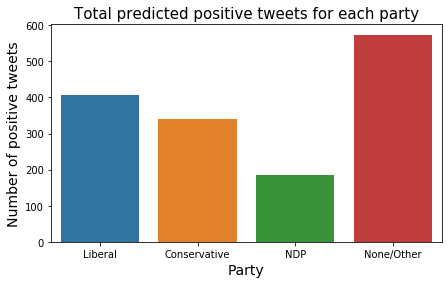

In [58]:
plt.figure(figsize=(7,4))
barplot = sns.barplot(x=pred_elections_df.index, y=pred_elections_df['sum'])
ax = barplot.axes
plt.ylabel("Number of positive tweets", fontsize=14)
plt.xlabel("Party", fontsize=14)
plt.title("Total predicted positive tweets for each party", fontsize=15)
plt.show()

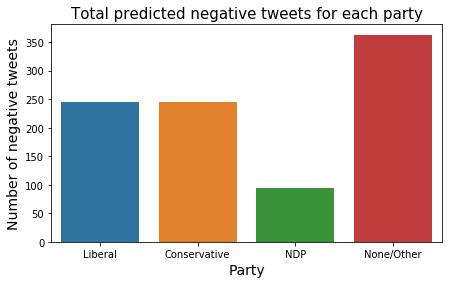

In [59]:
plt.figure(figsize=(7,4))
barplot = sns.barplot(x=elections_df.index, y=elections_df['length']-pred_elections_df['sum'])
ax = barplot.axes
plt.ylabel("Number of negative tweets", fontsize=14)
plt.xlabel("Party", fontsize=14)
plt.title("Total predicted negative tweets for each party", fontsize=15)
plt.show()

Text(0.5, 1.0, 'Ratio of predicted positive to negative tweets for each party')

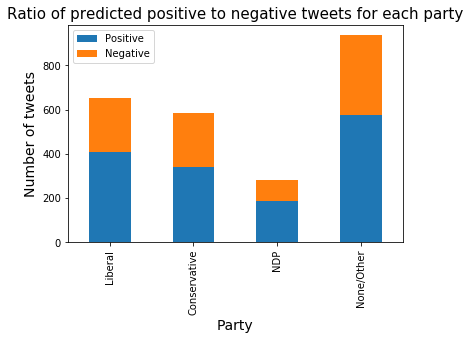

In [60]:
pos_neg = {'Positive': [pred_lib_sum, pred_con_sum, pred_ndp_sum, pred_none_sum], 'Negative': [len(liberal)-pred_lib_sum, len(conservative)-pred_con_sum, len(ndp)-pred_ndp_sum, len(none_tweet)-pred_none_sum]}
pos_neg_df = pd.DataFrame(data=pos_neg, index=['Liberal', 'Conservative', 'NDP', 'None/Other'])
pos_neg_df.plot(kind='bar',stacked=True)
plt.ylabel("Number of tweets", fontsize=14)
plt.xlabel("Party", fontsize=14)
plt.title("Ratio of predicted positive to negative tweets for each party", fontsize=15)

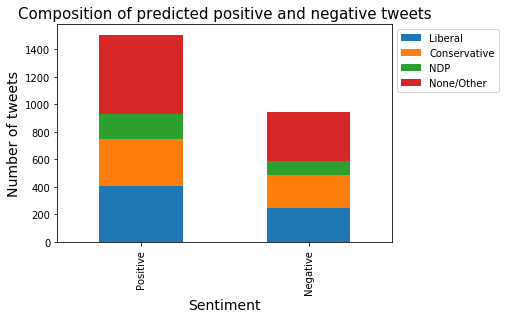

In [61]:
posneg_flipped = {'Liberal': [pred_lib_sum, len(liberal)-pred_lib_sum], 'Conservative': [pred_con_sum, len(conservative)-pred_con_sum],
             'NDP': [pred_ndp_sum, len(ndp)-pred_ndp_sum], 'None/Other': [pred_none_sum, len(none_tweet)-pred_none_sum]}
posneg_flipped_df = pd.DataFrame(data=posneg_flipped, index=['Positive', 'Negative'])
posneg_flipped_df.plot(kind='bar',stacked=True)
plt.ylabel("Number of tweets", fontsize=14)
plt.xlabel("Sentiment", fontsize=14)
plt.title("Composition of predicted positive and negative tweets", fontsize=15)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

Like the true sentiment data, the predict sentiment values shows some correlation with what actually happened during the elections. Liberal and Conservatives were the most popular two parties, gaining the majority of votes, while NDP had much less votes.

However, the prediction data differs from what was seen in the actual data in the number of negative tweets. As shown in the confusion matrices above, the model has a hard time predicting negative tweets (especially for those related to the Conservative party) and this is reflected in the predicted ratio of positive to negative tweets. While the actual sentiment values suggest that the Conservatives had much higher number of negative tweets than positive tweets, the predicted sentiment values show that there were more positive than negative tweets. Furthermore, the ratio between positive and negative for Liberal and Conservative seem very similar. So looking just from this bar graph, it is not possible to conclude which of the two parties Canadians look more favourably upon since the % positive and % negative tweets for Liberal and Conservative are very similar and seem to have no significant difference.

Based on the prediction data, we could infer that the Liberals and Conservatives are regarded both similarly (because of similar % positive tweets), with a possibly a slight advantage for the Liberals. The data also suggests that the NDP party is not as popular as Liberals or Conservatives, but they have a higher % of positive tweets. This may mean that less people are considering voting for them but within that small population of people, they are mostly supporters of the NDP party.

Even if the model had predicted the sentiment values with 100% accuracy, as previously stated in the exploratory analysis section, this data lacks geographical information. The actual sentiment data suggests that the there were much more negative tweets related to the Conservative party and so the Liberal party has an advantage. However, the Conservative had higher number of popular votes. This is not reflected in the Twitter data and this may be due to the lack of geographical data. The Twitter data may be more representative of a certain area of Canada where most of the Twitter users are. For example, if most of the tweets were made by users in Ontario, the sentiment data would have been able to correctly predict that the majority of the seats would be won by Liberals.

Therefore, although NLP analytics may be useful for political parties to see if there is a particular reason for negative tweets (e.g. blackface scandal), it is not helpful in being able to predict outcome of election particularly if there is no geographical data.

There are a couple of ways the accuracy of the model could be improved:

1) Thesaurus data can be used to group similar words together (e.g. vote, poll, election) so that these similar words will have similar sentiment values and won't be considered as having different sentiment values based on how frequent or infrequent it is used.

2) Use a deep neural network, which is able do feature engineering and make better use of the feature to allow for better classification as positive or negative sentiment. (Implemented in the 'Bonus' section).

3) Currently, the train f1 score is higher than the test f1 score, meaning that the model is overfitting. This may be because of the use of too many features. Thus, with less featuers, the model may be able to generalize better. (Regularization and hyperparameter tuning is implemented in the 'Bonus' section).

4) Since the model is currently having problems predicting negative tweets, collection of more negative tweet data may be able to able to help better consolidate what is considered a negative tweet.

## 4.1 Model preparation for predicting reason for negative sentiment

We will select all negative tweets and assign the vectorized text to X_neg and one hot encoded negative reason as y_neg.

In [62]:
negative_tweets = elections_original[elections_original['sentiment'] == 0]

X_neg = negative_tweets.text_cleaned
count_vectorizer = count_vect(4000)
tweets_vect = count_vectorizer.fit_transform(X_neg)
tweets_vect = tweets_vect.toarray()
tweets_vect_features = count_vectorizer.get_feature_names()
X_neg_vect = pd.DataFrame(tweets_vect, columns=tweets_vect_features)

y_neg = negative_tweets.negative_reason
le = preprocessing.LabelEncoder()
y_neg_encoded = le.fit_transform(y_neg)

The negative tweet data will be split into 30% test and 70% train.

In [63]:
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(X_neg_vect, y_neg_encoded, test_size=0.3, random_state=10)

## 4.2 Model implementation for predicting reason for negative sentiment

Three classification models will be tested: logistic regression, multinomial Naive Bayes, and random forests.

In [64]:
models=[]
models.append(('LR', LogisticRegression(multi_class='ovr')))
models.append(('NB', MultinomialNB()))
models.append(('RF', RandomForestClassifier(random_state=1)))

In [65]:
train_test(X_train_neg, X_test_neg, y_train_neg, y_test_neg, models)

With model LR , train f1: 0.9957386363636364 , and test f1: 0.5529801324503312
With model NB , train f1: 0.9133522727272727 , and test f1: 0.5264900662251656
With model RF , train f1: 0.9801136363636364 , and test f1: 0.5728476821192053


In [66]:
models=[]
models.append(('RF', RandomForestClassifier(random_state=1)))
test_predict = train_test(X_train_neg, X_test_neg, y_train_neg, y_test_neg, models, save=True)

With model RF , train f1: 0.9801136363636364 , and test f1: 0.5728476821192053


The best f1 score of 0.5728476821192053 was obtained with Random Forests.

## 4.3 Results of model for predicting reason for negative sentiment

In [67]:
print(classification_report(y_test_neg,test_predict))

              precision    recall  f1-score   support

           0       1.00      0.56      0.71        18
           1       0.75      0.18      0.29        17
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.50      0.84      0.63       106
           5       0.00      0.00      0.00         2
           6       0.66      0.56      0.61        77
           7       0.00      0.00      0.00         2
           8       0.62      0.37      0.47        67
           9       0.75      0.38      0.50         8

    accuracy                           0.57       302
   macro avg       0.43      0.29      0.32       302
weighted avg       0.60      0.57      0.55       302



In [68]:
cm = confusion_matrix(y_test_neg,test_predict,labels=np.sort(np.unique(y_test_neg)))

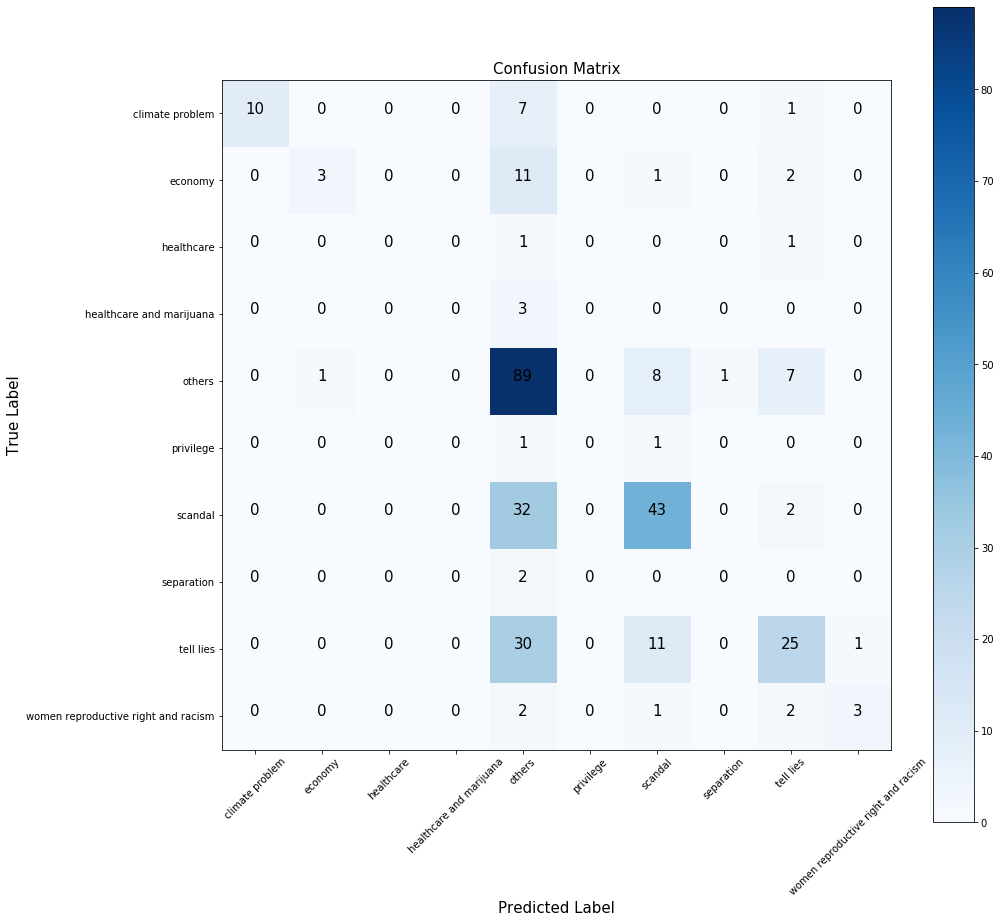

In [69]:
labels = le.inverse_transform(np.sort(np.unique(y_test_neg)))

plt.figure(figsize=(15,15))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(np.sort(np.unique(y_test_neg))))
plt.xticks(tick_marks, labels, rotation=45, fontsize=10)
plt.yticks(tick_marks, labels, fontsize=10)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 200:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

The current f1 score is low primarily due to the fact that the model is mostly predicted the reason as 'scandal', 'tell lies', and 'others'. This is because the majority of the data is skewed towards these three categories, thus the predictions are also skewed towards these three reasons. Furthermore, the hyperparameters for Random Forests is currently arbitrarily set to the default values, which is currently leading to overfitting as seen from the high train f1 score but low test f1 score. 

The accuracy of the model can be improved by:

1) Hyperparameter tuning maximum depth and the number of estimators so that the model may be able to better generalize. (Will be investigated in the 'Bonus' section)

2) Collecting more data so that there is similar number of data for each of the categories. This reduces the skew in the data, which will not push the model towards predictions based on frequency.

##  Bonus

## Additional exploratory analysis

We will take a closer look at what constitutes a tweet classified as 'None/Other'.

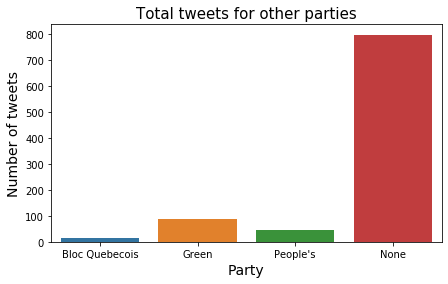

In [70]:
green = none_tweet[none_tweet['text'].str.contains('green|elizabeth|may', case=False)]
# Note: 'people' was not included in the search for tweets related to People's party since unrelated tweets may also be included
people = none_tweet[none_tweet['text'].str.contains('maxime|bernier', case=False)]
quebec = none_tweet[none_tweet['text'].str.contains('bloc|quebecois|yves|francois|blanchet', case=False)]
no_party = none_tweet[~none_tweet['text'].str.contains('bloc|quebecois|yves|francois|blanchet|green|elizabeth|may|maxime|bernier', case=False)]
other_data = {'length': [len(quebec), len(green), len(people), len(no_party)]}
other_df = pd.DataFrame(data=other_data, index=['Bloc Quebecois', 'Green', 'People\'s', 'None'])

plt.figure(figsize=(7,4))
barplot = sns.barplot(x=other_df.index, y=other_df['length'])
ax = barplot.axes
plt.ylabel("Number of tweets", fontsize=14)
plt.xlabel("Party", fontsize=14)
plt.title("Total tweets for other parties", fontsize=15)
plt.show()


Even if we look at tweets for other parties like Bloc Quebecois, Green, and People's, there's still a many tweets without any of the keywords for any of the parties. This may be because the keywords don't thoroughly identify all tweets related to parties (since there are many other people associated with each party, not necessarily just the candidates for PM), but it may also be because the tweets are generic tweets related to the election without the mention of a party.

Let's look at some of the tweets classified as 'None'.

In [71]:
print(no_party['text_cleaned'].values[:10])

['allwomanspacewalk real etobicokenorth cityofto onpoli cdnpoli elxn43'
 'canada canadaelection2019 canadavot elxn43 can decid should help'
 'cdnmedia elxn43 cdnpoli ppc rocki dong hand best elect video ever pleas googl rocki dong box social haven seen go rocki'
 'elxn43 two day away re vote e day read primer learn can vote can vote can vote how can vote'
 'icymi analysi how will ford nation respond renata ford peopl parti canada bid for etobicokenorth mp ballot box resid expert weigh vote2019 cdnpoli etobicok etobto'
 'icymi analysi how will ford nation respond renata ford peopl parti canada bid for etobicokenorth mp ballot box resid expert weigh vote2019 cdnpoli etobicok etobto'
 'threadalert studi sheet for unfit candid cdnpoli elxn2019 elxn43'
 'uptoyouth cdnpoli elxn43 today youth smart smarter averag adult can will chang world will chang world'
 'prof mari wiktorowicz weigh health care polici feder elect tvo elxn43'
 'hi alan m wonder could put quick social media messag import ge

For the most part these tweets are not related to a specific party. Some encourage to consider certain aspects such as healthcare when voting while other tweets are just to encourage more voting.

### Tuning the number of max features using bag of words for best prediction using Logistic Regression

In [72]:
def best_logistic(max_feat):
    print('With feat = ', max_feat)
    count_vectorizer = count_vect(max_feat)
    tweets_vect = count_vectorizer.fit_transform(tweets_df['tweet_cleaned'])
    tweets_vect = tweets_vect.toarray()
    tweets_vect_features = count_vectorizer.get_feature_names()

    X_train = pd.DataFrame(tweets_vect, columns=tweets_vect_features)
    y_train = tweets_df['sentiment'].copy()

    elections_vect = count_vectorizer.transform(elections_original['text_cleaned'])
    elections_vect = elections_vect.toarray()
    elections_vect_features = count_vectorizer.get_feature_names()

    X_test = pd.DataFrame(elections_vect, columns=elections_vect_features)
    y_test = elections_original['sentiment'].copy()

    bestmodel = [('LR', LogisticRegression())]
    train_test(X_train, X_test, y_train, y_test, bestmodel)

feats = np.linspace(500, 5000, 10, dtype=int)

# for feat in feats:
#     best_logistic(feat)

Therefore, the best number of features using CountVectorizer is 4000 features.

### Using a fully connected neural network to predict sentiment of generic twitter data and reason for negative tweet of elections data.

In [73]:
def fc_model(input_dim):
    model = Sequential()
    model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    model.summary()
    return model

In [74]:
# model = fc_model(X_train.shape[1])
# fit = model.fit(X_train, y_train, epochs=5, verbose=1, validation_split=0.2, batch_size=10)
# pred_probs = model.predict(X_test, verbose=0)
# pred_classes = model.predict_classes(X_test, verbose=0)
# f1 = f1_score(y_test, pred_classes, average='micro')
# print('F1 score: %f' % f1)

F1 score: 0.639006

The fully connected neural network was able to achieve a higher F1 score than logistic regression on the generic tweet data vectorized using bag of words.

In [75]:
# model = fc_model(X_train_neg.shape[1])
# fit = model.fit(X_train_neg, y_train_neg, epochs=5, verbose=1, validation_split=0.2, batch_size=10)
# pred_probs = model.predict(X_test_neg, verbose=0)
# pred_classes = model.predict_classes(X_test_neg, verbose=0)
# f1 = f1_score(y_test_neg, pred_classes, average='micro')
# print('F1 score: %f' % f1)

F1 score: 0.476821

When the fully connected neural network was used to predict reason for the negative tweet, it did worse than with logistic regression.

### Using an LSTM RNN with word embeddings to predict sentiments and reason for negative tweet.

In [76]:
def lstm(input_len):
    # create the model
    model = Sequential()
    model.add(Embedding(1000, 50, input_length=input_len))
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.50))
    model.add(Dense(10, activation='sigmoid'))
    # Adam Optimiser
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [77]:
# Was not able to implement since the ETA for 1 epoch was 34 hrs

# model = lstm(X_train.shape[1])
# fit = model.fit(X_train, y_train, epochs=1, verbose=1, validation_split=0.5, batch_size=10)
# pred_probs = model.predict(X_test, verbose=0)
# pred_classes = model.predict_classes(X_test, verbose=0)
# f1 = f1_score(y_test, pred_classes, average='micro')
# print('F1 score: %f' % f1)

In [78]:
# Takes long time to run so commented out (results are pasted below)

# model = lstm(X_train_neg.shape[1])
# fit = model.fit(X_train_neg, y_train_neg, epochs=2, verbose=1, validation_split=0.2, batch_size=10)
# pred_probs = model.predict(X_test_neg, verbose=0)
# pred_classes = model.predict_classes(X_test_neg, verbose=0)
# f1 = f1_score(y_test_neg, pred_classes, average='micro')
# print('F1 score: %f' % f1)

Train on 633 samples, validate on 71 samples

Epoch 1/2

633/633 [==============================] - 639s 1s/step - loss: 1.8204 - acc: 0.3491 - val_loss: 1.5115 - val_acc: 0.4507

Epoch 2/2
633/633 [==============================] - 639s 1s/step - loss: 1.6814 - acc: 0.3570 - val_loss: 1.4937 - val_acc: 0.4507

F1 score: 0.350993

## Tuning hyperparameters for logistic regression for prediction of sentiment values

In [79]:
# C = np.linspace(0.1, 10, 100)
# saved_acc = 0
# saved_c = 0
# for c in C:
#     clf = LogisticRegression(penalty='l1', C=c)
#     clf.fit(X_train_count, y_train_count)
#     test_predict = clf.predict(X_test_count)
#     test_acc = f1_score(test_predict, y_test_count, average='micro')
#     if test_acc > saved_acc:
#         saved_acc = test_acc
#         saved_c = c
    
# print('F1 score: %f' % saved_acc, 'with C: %f' % saved_c)

Best test accuracy was achieved with a C value of 0.4.

In [80]:
bestmodel = LogisticRegression(penalty='l1', C=0.4)
bestmodel.fit(X_train, y_train)
test_predict = bestmodel.predict(X_test)
test_acc = f1_score(test_predict, y_test, average='micro')
print('F1 score: %f' % test_acc)

F1 score: 0.639944


Therefore, the model slightly improved with tuning from f1 score of 0.6380684481950305 to 0.639944.

## Tuning hyperparameters for random forest for prediction of reason for negative sentiment

In [81]:
depths = [1000, 2000, 3000, 4000, 5000, 6000]
num_trees = [50, 60, 70, 80, 90, 100]
saved_depth = 10
saved_tree = 50
saved_acc = 0

# for depth in depths:
#     for num_tree in num_trees:
#         clf = RandomForestClassifier(random_state=1, max_depth=depth, n_estimators=num_tree)
#         clf.fit(X_train_neg[:500], y_train_neg[:500])
#         train_predict = clf.predict(X_train_neg[500:])
#         train_acc = f1_score(train_predict, y_train_neg[500:], average='micro')
#         if train_acc > saved_acc:
#             saved_acc = train_acc
#             saved_depth = depth
#             saved_tree = num_tree
    
# print('F1 score:', saved_acc, 'with num_tree:', saved_tree, 'and with depth:', saved_depth)


Best train accuracy was obtained with max depth of 100 and 50 estimators

In [82]:
bestmodel = RandomForestClassifier(random_state=1, max_depth=1000, n_estimators=50)
bestmodel.fit(X_train_neg, y_train_neg)
test_predict = bestmodel.predict(X_test_neg)
test_acc = f1_score(test_predict, y_test_neg, average='micro')
print('F1 score:', test_acc)

F1 score: 0.5761589403973509


Through hyperparameter training, the f1-score was increased from 0.5728476821192053 to 0.5761589403973509

### Using n-grams with bag of words and TF-IDF

#### Using bag of words and n-grams

In [83]:
count_vectorizer = CountVectorizer(max_features=4000, ngram_range=(1,2))
tweets_vect = count_vectorizer.fit_transform(tweets_df['tweet_cleaned'])
tweets_vect = tweets_vect.toarray()
tweets_vect_features = count_vectorizer.get_feature_names()

In [84]:
X_train = pd.DataFrame(tweets_vect, columns=tweets_vect_features)
y_train = tweets_df['sentiment'].copy()

In [85]:
elections_vect = count_vectorizer.transform(elections_original['text_cleaned'])
elections_vect = elections_vect.toarray()
elections_vect_features = count_vectorizer.get_feature_names()

In [86]:
X_test = pd.DataFrame(elections_vect, columns=elections_vect_features)
y_test = elections_original['sentiment'].copy()

In [87]:
bestmodel = LogisticRegression()
bestmodel.fit(X_train, y_train)
train_predict = bestmodel.predict(X_train)
test_predict = bestmodel.predict(X_test)
            
train_acc = f1_score(train_predict, y_train, average='micro')
test_acc = f1_score(test_predict, y_test, average='micro')

print('With model Logistic Regression, train f1:', train_acc, ', and test f1:', test_acc)

With model Logistic Regression, train f1: 0.79408 , and test f1: 0.646038443506798


Using n-grams with bag of words, the test f1 has increase from 0.6380684481950305 to 0.646038443506798.

#### Using TF-IDF and n-grams

In [88]:
tfidf_vectorizer = TfidfVectorizer(max_features=4000, ngram_range=(1,2))
tweets_vect = tfidf_vectorizer.fit_transform(tweets_df['tweet_cleaned'])
tweets_vect = tweets_vect.toarray()
tweets_vect_features = tfidf_vectorizer.get_feature_names()

In [89]:
X_train = pd.DataFrame(tweets_vect, columns=tweets_vect_features)
y_train = tweets_df['sentiment'].copy()

In [90]:
elections_vect = tfidf_vectorizer.transform(elections_original['text_cleaned'])
elections_vect = elections_vect.toarray()
elections_vect_features = tfidf_vectorizer.get_feature_names()

In [91]:
X_test = pd.DataFrame(elections_vect, columns=elections_vect_features)
y_test = elections_original['sentiment'].copy()

In [92]:
bestmodel = LogisticRegression()
bestmodel.fit(X_train, y_train)
train_predict = bestmodel.predict(X_train)
test_predict = bestmodel.predict(X_test)
            
train_acc = f1_score(train_predict, y_train, average='micro')
test_acc = f1_score(test_predict, y_test, average='micro')

print('With model Logistic Regression, train f1:', train_acc, ', and test f1:', test_acc)

With model Logistic Regression, train f1: 0.794615 , and test f1: 0.6446319737458978


Using n-grams with TF-IDF, the test f1 has increase from 0.6380684481950305 to 0.6446319737458978, but it is still lower than the f1-score obtained with using bag of words (0.646038443506798).